https://github.com/balandhanka/Windspeed-Forecasting-LSTM-GRU/blob/master/final_gru.ipynb

In [603]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

In [604]:
#importing files


from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from datetime import datetime
from sklearn.metrics import mean_squared_error

In [605]:
#reading dataset
headers = ['col1','col2','col3','date','landavgtemp','landavgtempuncertainity','lanmaxtemp','lanmaxtempuncertainity','landoceanavgtemp','landoceanavgtempuncertainity']
dtypes = {'col1':'str','col2':'str','col3':'str','date':'date','landavgtemp':'float','landavgtempuncertainity':'float','lanmaxtemp':'float','lanmaxtempuncertainity':'float',
          'landoceanavgtemp':'float','landoceanavgtempuncertainity':'float'}
dataset = pd.read_csv("sample_data/Surface Temperature Data.csv", parse_dates= True)


In [606]:
#vieweing the top 5 rows within the dataframe
dataset.head(5)


,Year,Months,Unnamed: 2,Date,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750,1.0,1.0,1/1/1750,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750,2.0,1.0,2/1/1750,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750,3.0,1.0,3/1/1750,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750,4.0,1.0,4/1/1750,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750,5.0,1.0,5/1/1750,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [607]:
#dropping columns that are not essential 
dataset.drop(columns  = ['Year','Months','Unnamed: 2','LandAverageTemperatureUncertainty','LandMaxTemperature','LandMaxTemperatureUncertainty','LandMinTemperature','LandMinTemperatureUncertainty',
                         'LandAndOceanAverageTemperature','LandAndOceanAverageTemperatureUncertainty'], inplace = True)

In [608]:
#final dataset after removing extra columns
dataset.head(5)

,Date,LandAverageTemperature
0,1/1/1750,3.034
1,2/1/1750,3.083
2,3/1/1750,5.626
3,4/1/1750,8.490
4,5/1/1750,11.573


In [609]:
#extracting year and month from the date column in the dataframe

dataset['date'] = pd.to_datetime(dataset['Date'])
dataset['yr'] = dataset['date'].map(lambda x:x.year)
dataset['m'] = dataset['date'].map(lambda x:x.month)

In [610]:
#calculating total how many number of years the db has
year_max = dataset['yr'].max()
year_min = dataset['yr'].min()

length = year_max - year_min +1

#creating a list of years to store all year values
years = [year_min]

for i in range (1, length):
  years.append(year_min + i)

In [611]:
#calculating the mean over a set of years since we are calculating yearly predictions

meantemperature = dataset['LandAverageTemperature'].groupby(dataset['yr']).mean()

In [612]:
#creating a new dataframe to store the data 

average = pd.DataFrame()
average['target']=meantemperature
average['Year']=years

average['Date']=pd.to_datetime(average['Year'], format='%Y')
length

266

In [613]:
average.set_index('Date',inplace=True)
average.head()

,target,Year
Date,,
1750-01-01,8.373542,1750
1751-01-01,7.684188,1751
1752-01-01,6.510208,1752
1753-01-01,8.388083,1753
1754-01-01,8.469333,1754


In [614]:
train = average[0:200]
test = average[200:]


In [615]:
training_set = dataset[:200].iloc[:,1:2].values
test_set = test.iloc[:,0:1].values
print(test_set.shape)

(66, 1)


In [616]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [617]:
X_train = []
y_train = []
for i in range(3,200):
    X_train.append(training_set_scaled[i-3:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [618]:
print(X_train[0:5])
print(y_train[0:5])

[[0.22105827 0.22344572 0.34734944]
 [0.22344572 0.34734944 0.48689339]
 [0.34734944 0.48689339 0.63710778]
 [0.48689339 0.63710778 0.70356656]
 [0.63710778 0.70356656 0.84637498]]
[0.48689339 0.63710778 0.70356656 0.84637498 0.79190216]


In [619]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape


(197, 3, 1)

In [620]:
y_train.shape

(197,)

In [621]:
dataset_total = pd.concat((average["target"][:200],average["target"][200:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 3:].values
inputs = inputs.reshape(-1,1)
sc1 = MinMaxScaler(feature_range=(0,1))
# inputs  = sc1.fit_transform(inputs)
inputs = sc.transform(inputs)
inputs.shape

(69, 1)

In [622]:
X_test = []
for i in range(3,69):
    X_test.append(inputs[i-3:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)

(66, 3, 1)


In [623]:

regressorGRU = Sequential()
regressorGRU.add(GRU(25, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorGRU.add(GRU(50, return_sequences=True))
regressorGRU.add(GRU(50))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))
regressorGRU.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['accuracy'])
regressorGRU.fit(X_train,y_train,epochs=20,batch_size=16,validation_split=0.20)

# regressorGRU = Sequential()
# regressorGRU.add(GRU(25, return_sequences=True, input_shape=(X_train.shape[1],1)))
# regressorGRU.add(GRU(50, return_sequences=True))
# regressorGRU.add(GRU(50))
# regressorGRU.add(Dropout(0.2))
# regressorGRU.add(Dense(units=1))
# regressorGRU.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['accuracy'])
# regressorGRU.fit(X_train,y_train,epochs=20,batch_size=32,validation_split=0.2)

Epoch 1/20
10/10 [==============================] - 7s 143ms/step - loss: 0.1012 - accuracy: 0.0064 - val_loss: 0.0363 - val_accuracy: 0.0000e+00
Epoch 2/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0561 - accuracy: 0.0064 - val_loss: 0.0351 - val_accuracy: 0.0000e+00
Epoch 3/20
10/10 [==============================] - 0s 12ms/step - loss: 0.0532 - accuracy: 0.0064 - val_loss: 0.0388 - val_accuracy: 0.0000e+00
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 0.0513 - accuracy: 0.0064 - val_loss: 0.0367 - val_accuracy: 0.0000e+00
Epoch 5/20
10/10 [==============================] - 0s 13ms/step - loss: 0.0530 - accuracy: 0.0127 - val_loss: 0.0373 - val_accuracy: 0.0000e+00
Epoch 6/20
10/10 [==============================] - 0s 12ms/step - loss: 0.0498 - accuracy: 0.0127 - val_loss: 0.0426 - val_accuracy: 0.0000e+00
Epoch 7/20
10/10 [==============================] - 0s 12ms/step - loss: 0.0458 - accuracy: 0.0127 - val_loss: 0.0460 - val_accur

In [624]:
GRU_predicted_avgtemp = regressorGRU.predict(X_test)
print(GRU_predicted_avgtemp.shape)

GRU_predicted_avgtemp = sc.inverse_transform(GRU_predicted_avgtemp)
print(GRU_predicted_avgtemp.shape)


(66, 1)
(66, 1)


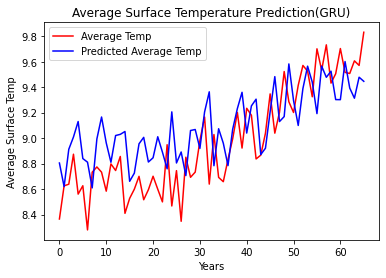

In [625]:
plt.plot(test_set, color='red',label='Average Temp')
plt.plot(GRU_predicted_avgtemp, color='blue',label='Predicted Average Temp')
plt.title('Average Surface Temperature Prediction(GRU)')
plt.xlabel('Years')
plt.ylabel('Average Surface Temp')
plt.legend()
plt.show()

In [626]:
rmse = math.sqrt(mean_squared_error(test_set, GRU_predicted_avgtemp))
print("The root mean squared error is {}.".format(rmse))
p = test_set.mean()
(rmse/p)*100

The root mean squared error is 0.31194669259685326.


3.475061354472379

In [627]:
MAP = np.mean(np.abs((test_set - GRU_predicted_avgtemp) / test_set)) * 100

In [628]:
print(MAP)

2.8565807265696552


In [629]:
temp = test_set[28:]
scaled_data = sc.transform(temp)
new_data = []

for i in range(len(scaled_data)-3):
  v = scaled_data[i:i+3]
  new_data.append(v)

new_data=np.array(new_data)
print('new_data.shape: ', new_data.shape)


new_data.shape:  (35, 3, 1)


In [630]:
#Predicting future values
GRU_predicted_avgtemp1 = regressorGRU.predict(new_data)
GRU_predicted_avgtemp1 = sc.inverse_transform(GRU_predicted_avgtemp1)

2049


Text(0, 0.5, 'Average Surface Temperature')

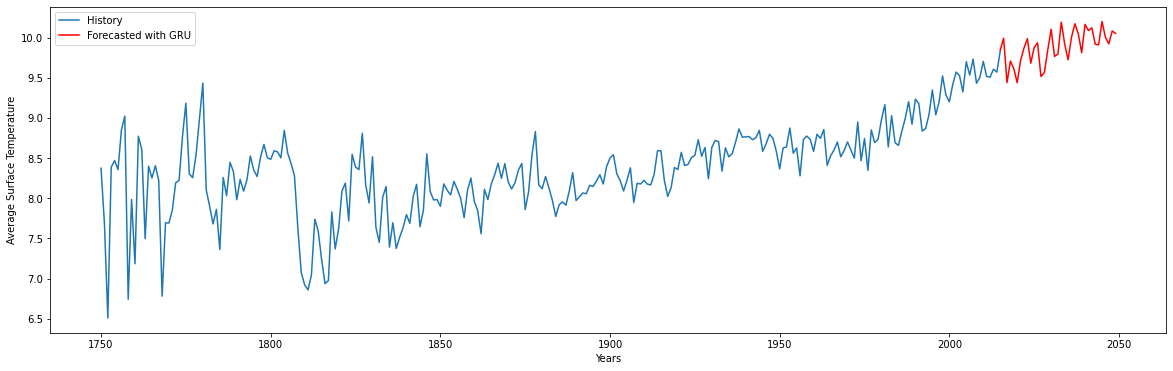

In [ ]:
plt.figure(figsize=(20, 6))
    
startsize= len(average)
futuresize = list(range(2015, 2015 + len(GRU_predicted_avgtemp1)))

plt.plot(1750 + np.arange(startsize), np.array(average['target']), label='History')
plt.plot(futuresize, np.array(GRU_predicted_avgtemp1),label='Forecasted with GRU', color='red')


plt.legend(loc='upper left')
plt.xlabel('Years')
plt.ylabel('Average Surface Temperature')

In [632]:
predicted_data = pd.DataFrame(GRU_predicted_avgtemp1)

In [633]:
predicted_data.columns=['Average Temperature']

#Printing a year list
year_list=[]
for i in range(1,36):
  year = 2015 + i
  year_list.append(year)

print(year_list)

[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050]


In [634]:
predicted_data['Year'] = year_list

In [635]:
predicted_data.head()

,Average Temperature,Year
0,9.204986,2016
1,9.363436,2017
2,8.783360,2018
3,9.073673,2019
4,8.959907,2020


In [636]:
year_val1 = predicted_data['Year']

predicted_data['Date'] = [str(year)+'/1/1' for year in year_val1]


predicted_data['Date'] = pd.to_datetime(predicted_data['Date'])

In [637]:
predicted_data.set_index('Date',inplace=True)
predicted_data.head()

,Average Temperature,Year
Date,,
2016-01-01,9.204986,2016
2017-01-01,9.363436,2017
2018-01-01,8.783360,2018
2019-01-01,9.073673,2019
2020-01-01,8.959907,2020


In [638]:
predicted_data = predicted_data.iloc[:, [1,0]]

In [639]:
predicted_data.head()

,Year,Average Temperature
Date,,
2016-01-01,2016,9.204986
2017-01-01,2017,9.363436
2018-01-01,2018,8.783360
2019-01-01,2019,9.073673
2020-01-01,2020,8.959907


In [640]:
average.head()

,target,Year
Date,,
1750-01-01,8.373542,1750
1751-01-01,7.684188,1751
1752-01-01,6.510208,1752
1753-01-01,8.388083,1753
1754-01-01,8.469333,1754


In [641]:
average1=average.rename(columns={ 'target':'Average Temperature'})
average1.head()

,Average Temperature,Year
Date,,
1750-01-01,8.373542,1750
1751-01-01,7.684188,1751
1752-01-01,6.510208,1752
1753-01-01,8.388083,1753
1754-01-01,8.469333,1754


In [642]:
forecast_data = average1.append(predicted_data)

In [643]:
forecast_data.tail()

,Average Temperature,Year
Date,,
2046-01-01,9.600914,2046
2047-01-01,9.392922,2047
2048-01-01,9.313317,2048
2049-01-01,9.478041,2049
2050-01-01,9.445789,2050


In [644]:
forecast_data.to_csv("Forecasted Surface Temperature Data.csv")

In [ ]:
#Accuracy = 100 - MAP
#Accuracy = 97.14%